In [2]:
import sys
sys.path.append('../')
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set(style='ticks', context='paper',
                               rc={'font.size': 6, 
                                   'axes.titlesize': 7,
                                   'axes.labelsize': 7,
                                   'axes.labelpad': 2,
                                   'xtick.labelsize': 5,
                                   'ytick.labelsize': 5,
                                   'legend.fontsize' : 5.5,
                                   'legend.markerscale': 0.5,
                                   'axes.spines.top': False,
                                   'axes.spines.right': False,
                                   'axes.linewidth': 0.4,
                                   'xtick.major.width': 0.4,
                                   'ytick.major.width': 0.4,
                                   'xtick.major.size': 2.5,
                                   'ytick.major.size': 2.5,
                                   'xtick.minor.size': 1.5,
                                   'ytick.minor.size': 1.5,
                                   'xtick.minor.width': 0.2,
                                   'ytick.minor.width': 0.2,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})
from matplotlib import pyplot as plt
from plotting import annotate_corr

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

---
# Dimensionality vs. encoding performance

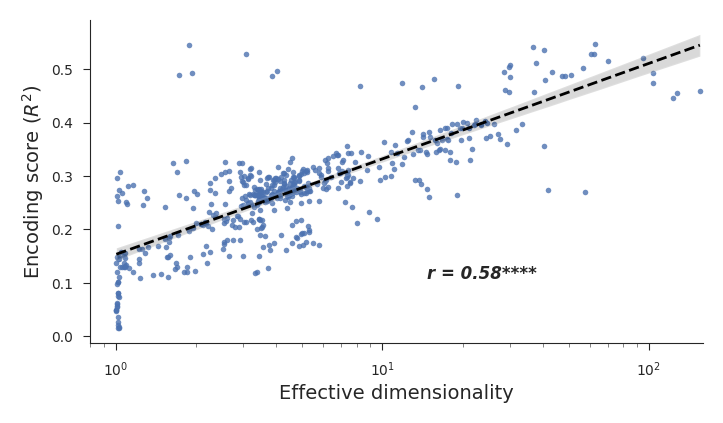

In [7]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 160)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.55, 0.2), ax=ax)

plt.savefig('saved/results_ED-vs-encoding.png', dpi=300)
plt.show()

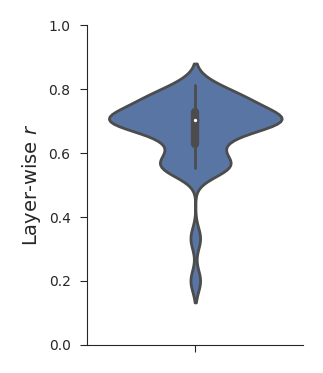

In [15]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 1.75))

sns.violinplot(data=data, y='r_score_dim', ax=ax, linewidth=1)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))

plt.savefig('saved/results_ED-vs-encoding-layerwise.png', dpi=300)
plt.show()

---
# Effect of training

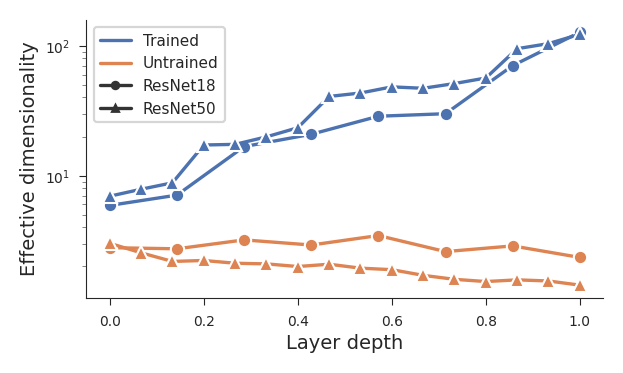

In [142]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[data.source == 'PyTorch']

for arch in data.architecture.unique():
    arch_layers = data[data.architecture == arch].layer.unique()
    arch_depth = {layer: i / (len(arch_layers) - 1) for i, layer in enumerate(arch_layers)}
    data.loc[data.architecture == arch, 'depth'] = data.loc[data.architecture == arch, 'layer'].map(arch_depth)

fig, ax = plt.subplots(figsize=(3, 1.75))

sns.lineplot(data=data, x='depth', y='effective dimensionality', 
             hue='kind', style='architecture', markers=['o', '^'], dashes=False,
             hue_order=['Supervised', 'Untrained'], style_order=['ResNet18', 'ResNet50'],
             ax=ax)
ax.set(xlabel='Layer depth', ylabel='Effective dimensionality', yscale='log')

handles, _ = ax.get_legend_handles_labels()
ax.legend(labels=['Trained', 'Untrained', 'ResNet18', 'ResNet50'], 
          handles=handles[1:3] + handles[-2:])

plt.savefig('saved/results_training.png', dpi=300)
plt.show()

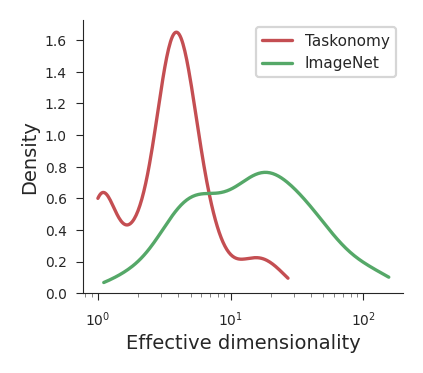

In [175]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['dataset'] = data['source'].map({'PyTorch': 'ImageNet', 'VVS': 'ImageNet', 'Taskonomy': 'Taskonomy'})
data = data[(data.kind != 'Untrained')]

fig, ax = plt.subplots(figsize=(2, 1.75))

sns.kdeplot(data=data, x='effective dimensionality', hue='dataset', 
            common_norm=False, cut=0, log_scale=True, 
            palette=sns.color_palette()[2:4], ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel='Density')

ax.legend(labels=['Taskonomy', 'ImageNet'])

plt.savefig('saved/results_dataset_and_task.png', dpi=300)
plt.show()

---
# Classification

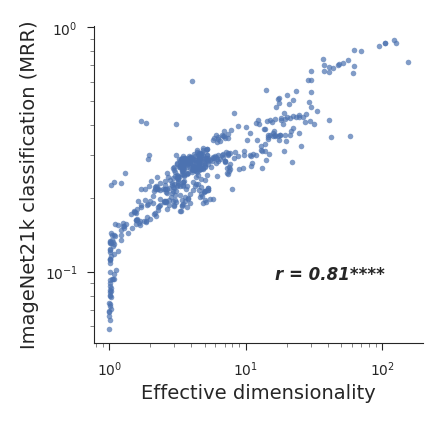

In [5]:
data = pd.read_csv(f'../../results/n-shot|dataset:imagenet21k|classifier:prototype|pooling:True.csv')
data = data[data.n_train == 50]
data = data.drop([c for c in data.columns if c not in id_columns + ['MRR']], axis='columns')
data = data.groupby(id_columns, as_index=False).mean()

dataset = 'imagenet'
data = pd.merge(data, 
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(figsize=(2.1, 2))

sns.scatterplot(data=data, x='effective dimensionality', y='MRR',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='Effective dimensionality', ylabel='ImageNet21k classification (MRR)')
annotate_corr(data, x='effective dimensionality', y='MRR', pos=(0.55, 0.2), ax=ax)

plt.savefig('saved/results_classification.png', dpi=300)
plt.show()

---
# Appendix - Dimensionality vs. encoding performance

## No spatial pooling

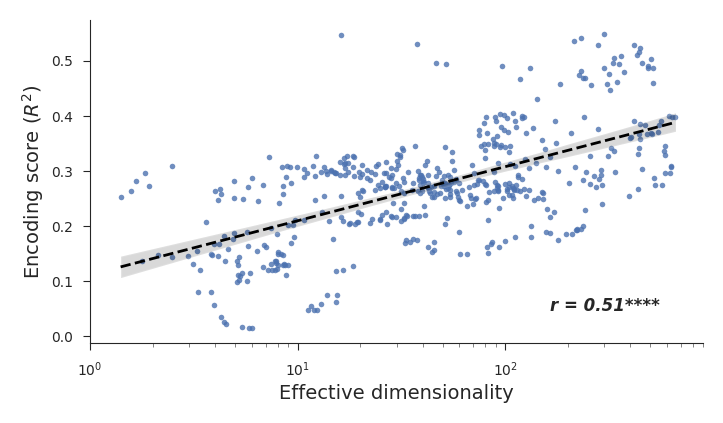

In [28]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:False|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(1, 900)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.75, 0.1), ax=ax)

plt.savefig('saved/appendix_nopool-ED-vs-encoding.png', dpi=300)
plt.show()

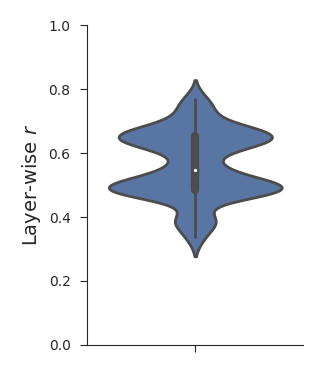

In [18]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:False|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 1.75))

sns.violinplot(data=data, y='r_score_dim', ax=ax, linewidth=1)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))

plt.savefig('saved/appendix_nopool-ED-vs-encoding-layerwise.png', dpi=300)
plt.show()

## By model kind

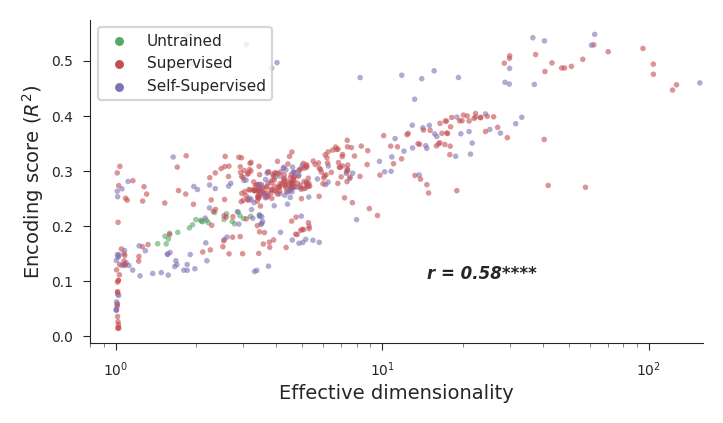

In [37]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 160)
sns.scatterplot(data=data, x='effective dimensionality', y='score', 
                hue='kind', palette=sns.color_palette()[2:5],
                alpha=0.6, s=4, linewidth=0,
                ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.55, 0.2), ax=ax)

ax.legend(loc='upper left')

plt.savefig('saved/appendix_bykind-ED-vs-encoding.png', dpi=300)
plt.show()

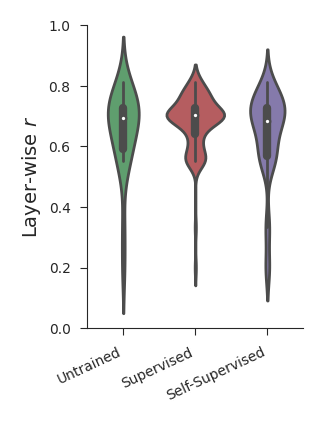

In [62]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 2))

sns.violinplot(data=data, y='r_score_dim', ax=ax, linewidth=1,
               x='kind', palette=sns.color_palette()[2:5])
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')

plt.savefig('saved/appendix_bykind-ED-vs-encoding-layerwise.png', dpi=300)
plt.show()

## Object2Vec

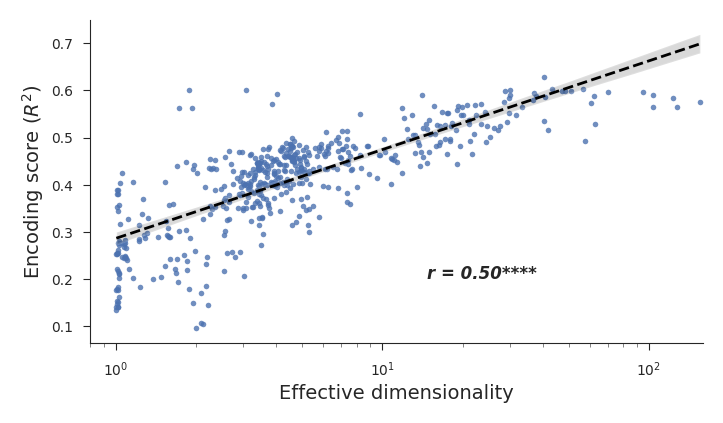

In [47]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:bonner.Object2Vec.pls.roi=LOC|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 160)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.55, 0.2), ax=ax)

plt.savefig('saved/appendix_object2vec-ED-vs-encoding.png', dpi=300)
plt.show()

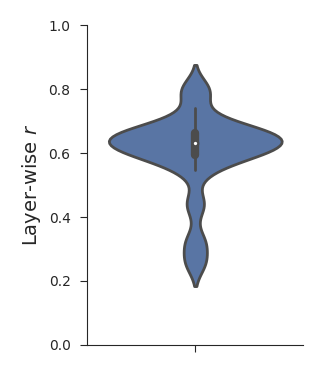

In [49]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:bonner.Object2Vec.pls.roi=LOC|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 1.75))

sns.violinplot(data=data, y='r_score_dim', ax=ax, linewidth=1)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))

plt.savefig('saved/appendix_object2vec-ED-vs-encoding-layerwise.png', dpi=300)
plt.show()